Requirements


In [ ]:
!pip install datasets
!pip install gensim
!pip install itertools
from datasets import load_dataset
from google.colab import drive, files
drive.mount('/content/drive')
import nltk
from nltk import wsd
from nltk.wsd import lesk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('wordnet2022')
nltk.download('punkt')
import pandas as pd
import string, re
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import codecs
import math
from statistics import mean
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from itertools import combinations

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
Mounted at /content/drive


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet2022 to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!pip freeze > requirements.txt

Loading the model for each subreddit

In [ ]:
askreddit_model = Word2Vec.load("/content/drive/MyDrive/Colab Notebooks/askreddit_model.model")
relation_model = Word2Vec.load("/content/drive/MyDrive/Colab Notebooks/relation_model.model")
league_model = Word2Vec.load("/content/drive/MyDrive/Colab Notebooks/league_model.model")
tifu_model = Word2Vec.load("/content/drive/MyDrive/Colab Notebooks/tifu_model.model")

Check the vector representation and word similarity. Code taken from https://colab.research.google.com/drive/1NIF8k_bomrd6ELT9TDjOE7eZUfQaYBhp

In [ ]:
# check if the model works how it should
def check_vectors(model):
  ok_list = ['okay', 'ok', 'Ok', 'O.K', 'okey', 'k']
  for word in ok_list:
    if word in model.wv:
      similar_words = model.wv.most_similar(word, topn=100)  # get other similar words
      vector_representation = model.wv[word].reshape(-1, 1) #reshape needed for plotting
      print("The most similar words to", word, " are:", similar_words)
      print("Vector representation of", word, ":", vector_representation)

  return similar_words, vector_representation

check_vectors(tifu_model)
check_vectors(askreddit_model)
check_vectors(league_model)
check_vectors(relation_model)

The most similar words to okay  are: [('ok', 0.9644312262535095), ('alright', 0.9379029870033264), ('fine', 0.7838194966316223), ('overreacting', 0.7311502695083618), ('yeah', 0.7125846147537231), ('allright', 0.7020798921585083), ('Ok', 0.6945436596870422), ('nno', 0.6804693341255188), ('O.K', 0.676723062992096), ('yea', 0.6718183159828186), ('sweety', 0.6693788170814514), ('errr', 0.658793032169342), ('generai', 0.652755618095398), ('okayyy', 0.6508872509002686), ('fuckit', 0.6500615477561951), ('yrrah321', 0.6456648707389832), ('nononono', 0.6449363827705383), ('nah', 0.6404300928115845), ('naw', 0.6367669105529785), ('fineso', 0.6363891959190369), ('yesss', 0.6341322064399719), ('dexi', 0.6329312324523926), ('bluffing', 0.632746696472168), ('cool', 0.6321579813957214), ('epo916', 0.6311584115028381), ('whew', 0.6309540271759033), ('yeh', 0.6299079060554504), ('uuuh', 0.6271770000457764), ('msgs', 0.6207608580589294), ('fmo', 0.6139156818389893), ('holyshit', 0.6134765148162842), ('

([('john', 0.8099661469459534),
  ('j', 0.8054457306861877),
  ('jane', 0.7884157299995422),
  ('h', 0.7835610508918762),
  ('sarah', 0.7702620029449463),
  ('bob', 0.7672289609909058),
  ('sam', 0.7649295330047607),
  ('r', 0.761006772518158),
  ('joe', 0.760854184627533),
  ('emily', 0.7602309584617615),
  ('josh', 0.757692277431488),
  ('amanda', 0.754801332950592),
  ('l', 0.7467742562294006),
  ('evan', 0.7466155290603638),
  ('dave', 0.7428257465362549),
  ('melissa', 0.73409104347229),
  ('jason', 0.731403648853302),
  ('g', 0.7306396961212158),
  ('e', 0.7299723625183105),
  ('anna', 0.7281407117843628),
  ('liz', 0.7271677255630493),
  ('mary', 0.7262797951698303),
  ('girl2', 0.724912703037262),
  ('katie', 0.7219940423965454),
  ('matt', 0.7213563323020935),
  ('kyle', 0.7184858322143555),
  ('george', 0.7165716886520386),
  ('steve', 0.7156975865364075),
  ('jessica', 0.7124914526939392),
  ('linda', 0.7112780809402466),
  ('luke', 0.7105823755264282),
  ('sally', 0.7096936

Get the most frequent OKs and their scores

In [ ]:
# Final version of the ok_list defined
ok_list = ['okay', 'ok', 'Ok', 'O.K', 'okey', 'k']

# Get the most common word similar to each word in the ok_list
def most_common_ok_score(model, n, ok_list):
  diction = dict()
  for ok in ok_list:
    similar_words = model.wv.most_similar(ok, topn=n)
    diction[ok] = similar_words
  return diction

# Get the most common word similar to each word in the ok_list excluding their scores
def most_common_ok_no(model, n, ok_list):
  diction = dict()
  for ok in ok_list:
    similar_words = model.wv.most_similar(ok, topn=n)
    diction[ok] = [i for i,x in similar_words ] #if i not in ok_list
  return diction


tifu_sim_ok = most_common_ok_score(tifu_model, 10, ok_list)
askreddit_sim_ok = most_common_ok_score(askreddit_model, 10, ok_list)
league_sim_ok = most_common_ok_score(league_model, 10, ok_list)
relation_sim_ok = most_common_ok_score(relation_model, 10, ok_list)

print("Askreddit:", askreddit_sim_ok)
print("League of Legends:", league_sim_ok)
print("TIFU", tifu_sim_ok)
print("Relationships", relation_sim_ok)

print("----------------------------------------")

print("Askreddit:", most_common_ok_no(askreddit_model, 5, ok_list))
print("League of Legends", most_common_ok_no(league_model, 5, ok_list))
print("TIFU", most_common_ok_no(tifu_model, 5, ok_list))
print("Relationships", most_common_ok_no(relation_model, 5, ok_list))


Askreddit: {'okay': [('ok', 0.9633913040161133), ('alright', 0.9083358645439148), ('fine', 0.79073566198349), ('allright', 0.7326062917709351), ('mhm', 0.7291162610054016), ('yeah', 0.7067393064498901), ('O.K', 0.7034212350845337), ('matteroffactly', 0.7020715475082397), ('boredlike', 0.6946085691452026), ('yea', 0.686814546585083)], 'ok': [('okay', 0.9633912444114685), ('alright', 0.9201911091804504), ('fine', 0.7963669300079346), ('allright', 0.716921329498291), ('mhm', 0.7166329622268677), ('O.K', 0.7002533674240112), ('yeah', 0.6903159022331238), ('yes', 0.6871501207351685), ('matteroffactly', 0.6864911317825317), ('hmmmmm', 0.6782957911491394)], 'Ok': [('yeah', 0.7604835629463196), ('uh', 0.7435232400894165), ('yea', 0.7343980669975281), ('mhm', 0.7170719504356384), ('ummmm', 0.7146096229553223), ('hmmm', 0.7010698914527893), ('uhhhhh', 0.699061393737793), ('hey', 0.6986126899719238), ('uhmm', 0.693945050239563), ('', 0.6909397840499878)], 'O.K': [('poopie', 0.8224467039108276), (

 ## Word Sense Similarity and Lesk Algorithm

Get the word wense for each OK

In [ ]:
# We use the built-in wordnet function from nltk to determine all possible
# definitions for each "ok" given by wordnet.
wordnet_ok_list = ['ok', 'okay', 'Ok', 'O.K.', 'k', 'okey']

# We pass each version of "ok" into the function and print out every entry.
def get_word_sense(strg):
  print(f"WordNet definitions for {strg}")
  i = 0
  for entry in wn.synsets(strg):
    print(f"definition {i}: {entry.definition()}")
    i += 1
  print("_____________________________________________________________________")

for ok in wordnet_ok_list:
  get_word_sense(ok)

WordNet definitions for ok
definition 0: a state in south central United States
definition 1: an endorsement
definition 2: being satisfactory or in satisfactory condition
definition 3: an expression of agreement normally occurring at the beginning of a sentence
_____________________________________________________________________
WordNet definitions for okay
definition 0: an endorsement
definition 1: give sanction to
definition 2: being satisfactory or in satisfactory condition
definition 3: in a satisfactory or adequate manner; ; ; (`alright' is a nonstandard variant of `all right')
_____________________________________________________________________
WordNet definitions for Ok
definition 0: a state in south central United States
definition 1: an endorsement
definition 2: being satisfactory or in satisfactory condition
definition 3: an expression of agreement normally occurring at the beginning of a sentence
_____________________________________________________________________
WordNet

In [ ]:
# In this step we use nltk wordnet to print out all POS-Tags for each "ok".
for ok in wordnet_ok_list:
  print(f"POS-TAGS for {ok}")
  print(wn.synsets(ok))
  print("_________________________________________________________________")

POS-TAGS for ok
[Synset('oklahoma.n.01'), Synset('o.k..n.01'), Synset('all_right.s.01'), Synset('very_well.r.02')]
_________________________________________________________________
POS-TAGS for okay
[Synset('o.k..n.01'), Synset('approve.v.01'), Synset('all_right.s.01'), Synset('okay.r.01')]
_________________________________________________________________
POS-TAGS for Ok
[Synset('oklahoma.n.01'), Synset('o.k..n.01'), Synset('all_right.s.01'), Synset('very_well.r.02')]
_________________________________________________________________
POS-TAGS for O.K.
[Synset('o.k..n.01'), Synset('approve.v.01'), Synset('all_right.s.01'), Synset('okay.r.01')]
_________________________________________________________________
POS-TAGS for k
[Synset('kelvin.n.01'), Synset('potassium.n.01'), Synset('thousand.n.01'), Synset('kilobyte.n.01'), Synset('kilobyte.n.02'), Synset('k.n.06'), Synset('k.n.07'), Synset('thousand.s.01')]
_________________________________________________________________
POS-TAGS for okey

In [ ]:
# This function mainly serves to have each "ok" dictionary without the similarity
# scores for the similar words to make the next step easier.
def join_dict_elemnts(dictionary):
  joined_dict = dict()
  for key, value in dictionary.items():
    joined_dict[key] = [i[0] for i in value]
  return joined_dict

relation_sim_ok_join = join_dict_elemnts(relation_sim_ok)
tifu_sim_ok_join = join_dict_elemnts(tifu_sim_ok)
askreddit_sim_ok_join = join_dict_elemnts(askreddit_sim_ok)
league_sim_ok_join = join_dict_elemnts(league_sim_ok)

print(relation_sim_ok_join)
print(tifu_sim_ok_join)
print(askreddit_sim_ok_join)
print(league_sim_ok_join)

{'okay': ['ok', 'alright', 'fine', 'okey', 'allright', 'cool', 'yeah', 'yea', 'retorted', 'sarcastically'], 'ok': ['okay', 'fine', 'alright', 'allright', 'okey', 'retorted', 'cool', 'yea', 'sarcastically', 'yes'], 'Ok': ['yeah', 'thanksokay', 'hey', 'rr_a', 'alright', 'helpok', 'umm', 'okey', 'nowhey', 'radvice'], 'O.K': ['concur', 'mutuals', 'tabled', 'sidekick', 'bullcrap', 'oppressing', 'nuff', 'overtures', 'misinformation', 'allconsuming'], 'okey': ['ahah', 'rehearsed', 'ehhhh', 'wha', 'noncommital', 'nooooo', 'mhm', 'gee', 'ondine', 'ummm'], 'k': ['john', 'j', 'jane', 'h', 'sarah', 'bob', 'sam', 'r', 'joe', 'emily']}
{'okay': ['ok', 'alright', 'fine', 'overreacting', 'yeah', 'allright', 'Ok', 'nno', 'O.K', 'yea'], 'ok': ['okay', 'alright', 'fine', 'yeah', 'O.K', 'overreacting', 'allright', 'sweety', 'yea', 'nno'], 'Ok': ['yeah', 'eh', 'okay', 'yea', 'yrrah321', 'shablabla', 'hey', 'errr', 'nvm', 'ok'], 'O.K': ['poogadi', 'bluffing', 'excommunicated', 'rue', 'honoured', 'coached', 

Lesk Algorithm

In [ ]:
# A simple approach to run the Lesk algorithm: for each subreddit we give each
# variation of "ok" and define the context by the most similar words.
# We get the definition for each "ok" in all subreddits based on the Lesk
# algorithm.
def lesk_algo(context):
  for key, value in zip(wordnet_ok_list, context.values()):
    if value:
      print(f"Results from Lesk algorithm for {key}")
      print(wsd.lesk(value, key).definition())
      print("------------------------------------------------------------------")

print("RESULTS FOR THE SUBREDDIT: RELATION")
lesk_algo(relation_sim_ok_join)
print("__________________________________________________________________\n")
print("RESULTS FOR THE SUBREDDIT: TIFU")
lesk_algo(tifu_sim_ok_join)
print("__________________________________________________________________\n")
print("RESULTS FOR THE SUBREDDIT: ASKREDDIT")
lesk_algo(askreddit_sim_ok_join)
print("__________________________________________________________________\n")
print("RESULTS FOR THE SUBREDDIT: LEAGUE")
lesk_algo(league_sim_ok_join)

RESULTS FOR THE SUBREDDIT: RELATION
Results from Lesk algorithm for ok
an expression of agreement normally occurring at the beginning of a sentence
------------------------------------------------------------------
Results from Lesk algorithm for okay
in a satisfactory or adequate manner; ; ; (`alright' is a nonstandard variant of `all right')
------------------------------------------------------------------
Results from Lesk algorithm for Ok
an expression of agreement normally occurring at the beginning of a sentence
------------------------------------------------------------------
Results from Lesk algorithm for O.K.
in a satisfactory or adequate manner; ; ; (`alright' is a nonstandard variant of `all right')
------------------------------------------------------------------
Results from Lesk algorithm for k
denoting a quantity consisting of 1,000 items or units
------------------------------------------------------------------
Results from Lesk algorithm for okey
an endorsement
--

In [ ]:
# In this step we want to see how many matches we get for each definition for all
# "ok"s across subreddits.
# Exclamation: part of this code was taken from Gemini to make the code run.
def modified_lesk(context_sentence, ambiguous_word):
    context = word_tokenize(context_sentence)
    synset = lesk(context, ambiguous_word)
    if synset is not None:
        definition = synset.definition()
        definition_words = word_tokenize(definition)
        overlap = set(context).intersection(definition_words)
        return len(overlap)
    else:
        return 0


def get_num_matches(wordnet_ok_list, dictionary):
  for key, value in zip(wordnet_ok_list, dictionary.values()):
    num_matches = modified_lesk(" ".join(value), key)
    print(num_matches)


get_num_matches(wordnet_ok_list, relation_sim_ok_join)
print("__")
get_num_matches(wordnet_ok_list, tifu_sim_ok_join)
print("__")
get_num_matches(wordnet_ok_list, askreddit_sim_ok_join)
print("__")
get_num_matches(wordnet_ok_list, league_sim_ok_join)

0
1
0
0
0
0
__
0
1
0
0
0
0
__
0
1
0
0
0
0
__
0
1
0
0
0
0


## Word Overlapping semantic similarity analysis accross subredits

In [ ]:
#this function gets the most similar words in two subreddits and extract only the
# overlapping ones to store them in a dictionary.
def get_most_similar_words(lst1, lst2):

  lst1_all_words = dict()
  overlap_words = dict()
  for i in ok_list:
    lst1_all_words[i] = [x[0] for x in lst1[i]]
    overlap_words[i] = [x[0] for x in lst2[i] if x[0] in lst1_all_words[i]]

  return overlap_words

pair1 = get_most_similar_words(tifu_sim_ok, askreddit_sim_ok)
print(pair1)
pair2 = get_most_similar_words(league_sim_ok, relation_sim_ok)
print(pair2)
pair3 = get_most_similar_words(tifu_sim_ok, league_sim_ok)
print(pair3)
pair4 = get_most_similar_words(askreddit_sim_ok, relation_sim_ok)
print(pair4)
pair5 = get_most_similar_words(tifu_sim_ok, relation_sim_ok)
print(pair5)
pair6 = get_most_similar_words(askreddit_sim_ok, league_sim_ok)
print(pair6)


{'okay': ['ok', 'alright', 'fine', 'allright', 'yeah', 'O.K', 'yea'], 'ok': ['okay', 'alright', 'fine', 'allright', 'O.K', 'yeah'], 'Ok': ['yeah', 'yea', 'hey'], 'O.K': [], 'okey': [], 'k': ['j', 'g', 'l']}
{'okay': ['ok', 'alright', 'fine', 'okey', 'yeah', 'yea'], 'ok': ['okay', 'fine', 'alright', 'yea'], 'Ok': ['yeah', 'hey', 'alright'], 'O.K': [], 'okey': [], 'k': []}
{'okay': ['ok', 'alright', 'yeah', 'fine', 'Ok', 'yea'], 'ok': ['okay', 'alright', 'yeah', 'fine', 'yea'], 'Ok': ['yeah', 'hey', 'yea', 'okay'], 'O.K': [], 'okey': [], 'k': []}
{'okay': ['ok', 'alright', 'fine', 'allright', 'yeah', 'yea'], 'ok': ['okay', 'fine', 'alright', 'allright', 'yes'], 'Ok': ['yeah', 'hey'], 'O.K': [], 'okey': [], 'k': ['j']}
{'okay': ['ok', 'alright', 'fine', 'allright', 'yeah', 'yea'], 'ok': ['okay', 'fine', 'alright', 'allright', 'yea'], 'Ok': ['yeah', 'hey'], 'O.K': [], 'okey': [], 'k': ['j', 'h', 'r']}
{'okay': ['ok', 'alright', 'yeah', 'fine', 'yea'], 'ok': ['okay', 'alright', 'yeah', 'fin

We get the scores of each OK from each subreddit in each pair.

In [ ]:
# This function extracts the scores of the overlapping words needed
# to compute the mean from the most_common_ok_score function ran beforehand
def get_scores(lst, pairs):
  lst_scores = []
  for ok in ok_list:
    for i in range(0, len(lst[ok])):
      if lst[ok][i][0] in pairs[ok]:
        lst_scores.append(lst[ok][i][1])
  return lst_scores


scores_tifu_sim_ok1 = get_scores(tifu_sim_ok, pair1)
scores_askreddit_sim_ok1 = get_scores(askreddit_sim_ok, pair1)

scores_league_sim_ok2 = get_scores(league_sim_ok, pair2)
scores_relation_sim_ok2 = get_scores(relation_sim_ok, pair2)

scores_tifu_sim_ok3 =get_scores(tifu_sim_ok, pair3)
scores_league_sim_ok3 = get_scores(league_sim_ok, pair3)

scores_askreddit_sim_ok4 = get_scores(askreddit_sim_ok, pair4)
scores_relation_sim_ok4 = get_scores(relation_sim_ok, pair4)

scores_tifu_sim_ok5 = get_scores(tifu_sim_ok, pair5)
scores_relation_sim_ok5 = get_scores(relation_sim_ok, pair5)

scores_askreddit_sim_ok6 = get_scores(askreddit_sim_ok, pair6)
scores_league_sim_ok6 = get_scores(league_sim_ok, pair6)

scores_tifu_sim_ok1, scores_askreddit_sim_ok1, scores_league_sim_ok2, scores_relation_sim_ok2, scores_tifu_sim_ok3, scores_league_sim_ok3, scores_askreddit_sim_ok4, scores_relation_sim_ok4, scores_tifu_sim_ok5, scores_relation_sim_ok5, scores_askreddit_sim_ok6, scores_league_sim_ok6

([0.9644312262535095,
  0.9379029870033264,
  0.7838194966316223,
  0.7125846147537231,
  0.7020798921585083,
  0.676723062992096,
  0.6718183159828186,
  0.96443110704422,
  0.9195398092269897,
  0.8042954206466675,
  0.7382264137268066,
  0.7133669853210449,
  0.7086279392242432,
  0.7359291911125183,
  0.692688524723053,
  0.6686069965362549,
  0.7619493007659912,
  0.7294438481330872,
  0.7105731964111328],
 [0.9633913040161133,
  0.9083358645439148,
  0.79073566198349,
  0.7326062917709351,
  0.7067393064498901,
  0.7034212350845337,
  0.686814546585083,
  0.9633912444114685,
  0.9201911091804504,
  0.7963669300079346,
  0.716921329498291,
  0.7002533674240112,
  0.6903159022331238,
  0.7604835629463196,
  0.7343980669975281,
  0.6986126899719238,
  0.8326447010040283,
  0.763289213180542,
  0.7329298257827759],
 [0.9118162393569946,
  0.8528910279273987,
  0.7660967111587524,
  0.7124432921409607,
  0.6842204332351685,
  0.6802433729171753,
  0.9118161797523499,
  0.7909182906150

Get the mean of the Oks in each pair to then, the mean of the overlapping similar words of each OKs

In [ ]:
# This function calculates the mean score between the first two scores from the different
# subredddits inside each pairs. Once, we have that mean score for each word in the overlapping
# word list, we compute the mean accross all the words in the list, therefore, we calculate for the
# length of the list.

def calc_avrg(lst1, lst2, pairs):
  lst_avrg = []
  average_oks = []
  for i, z in zip(lst1, lst2):
    lst_avrg.append((i+z)/2)
  for ok in ok_list:
    if len(pairs[ok]) != 0:
      avrg = 0
      for i in lst_avrg[:len(pairs[ok])]:
          avrg += i
      average_oks.append(avrg/len(pairs[ok]))
  print(lst_avrg)
  return average_oks

avrg_tifu_ask = calc_avrg(scores_tifu_sim_ok1, scores_askreddit_sim_ok1, pair1)
avrg_league_relation = calc_avrg(scores_league_sim_ok2, scores_relation_sim_ok2, pair2)
avrg_tifu_league = calc_avrg(scores_tifu_sim_ok3, scores_league_sim_ok3, pair3)
avrg_askreddit_relation = calc_avrg(scores_askreddit_sim_ok4, scores_relation_sim_ok4, pair4)
avrg_tifu_relation = calc_avrg(scores_tifu_sim_ok5, scores_relation_sim_ok5, pair5)
avrg_askreddit_league = calc_avrg(scores_askreddit_sim_ok6, scores_league_sim_ok6, pair6)

len(avrg_tifu_ask), len(avrg_league_relation)
avrg_league_relation, avrg_tifu_ask, avrg_tifu_league, avrg_askreddit_relation, avrg_tifu_relation, avrg_askreddit_league

[0.9639112651348114, 0.9231194257736206, 0.7872775793075562, 0.7225954532623291, 0.7044095993041992, 0.6900721490383148, 0.6793164312839508, 0.9639111757278442, 0.9198654592037201, 0.800331175327301, 0.7275738716125488, 0.7068101763725281, 0.6994719207286835, 0.748206377029419, 0.7135432958602905, 0.6836098432540894, 0.7972970008850098, 0.7463665306568146, 0.7217515110969543]
[0.9360474944114685, 0.8639378249645233, 0.8129724860191345, 0.686565637588501, 0.6392016410827637, 0.6369319558143616, 0.9360475540161133, 0.8352232277393341, 0.7987998425960541, 0.6654261648654938, 0.7326669991016388, 0.7122202217578888, 0.6916857361793518]
[0.9381237328052521, 0.8953970074653625, 0.7749581038951874, 0.7125139534473419, 0.6987757980823517, 0.6780193746089935, 0.9381236433982849, 0.8552290499210358, 0.7921515703201294, 0.7417953312397003, 0.7103915214538574, 0.7416326105594635, 0.7074558436870575, 0.6982949078083038, 0.6858074367046356]
[0.9618350267410278, 0.8916602432727814, 0.8252919614315033,

([0.7626095066467921, 0.8248808607459068, 0.8709859351317087],
 [0.7815288433006832,
  0.7985642453034719,
  0.8914360900719961,
  0.8914360900719961],
 [0.7829646617174149, 0.8039537191390991, 0.830248199403286],
 [0.7759039451678594,
  0.8030412256717682,
  0.9267476350069046,
  0.9618350267410278],
 [0.7745717416206995,
  0.8029422044754029,
  0.9343993961811066,
  0.8968775570392609],
 [0.7983484387397766, 0.8265561759471893, 0.865544468164444])

Get the final mean score for the word semantic similarity

In [ ]:
# Get the final mean score for each OK accross subreddits.
# Parts of this code was taken form Gemini to solve the problem
# of iterating through more than three lists.
ok_scores_dict = {}

ok_lssttsst = ["ok", "okay", "Ok", "k"]
# Use itertools.chain to flatten the lists of scores into a single iterable
all_scores = itertools.chain(avrg_tifu_ask[:-1], avrg_league_relation, avrg_askreddit_league, avrg_askreddit_relation, avrg_tifu_league, avrg_tifu_relation)

# Iterate over the oks and scores, taking two scores for each ok
for ok, score1, score2 in zip(ok_lssttsst, all_scores, all_scores):
    ok_scores_dict[ok] = (score1 + score2) / 2  # Calculate the average

ok_scores_dict = ok_scores_dict
print(ok_scores_dict)

{'ok': 0.7900465443020775, 'okay': 0.8270227983593941, 'Ok': 0.8479333979388077, 'k': 0.812452307343483}


Plot results

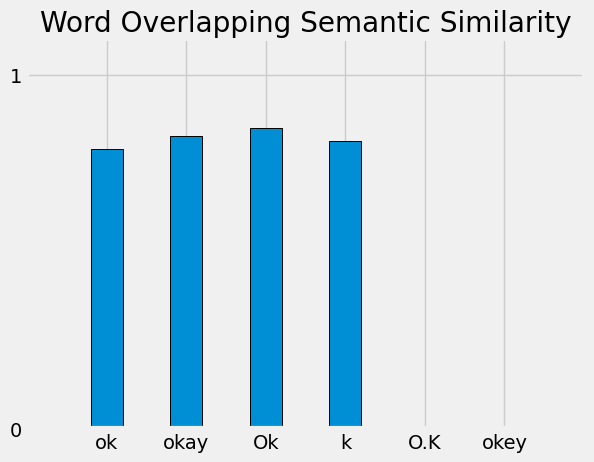

In [ ]:
def plot_sentiment(result, title):
  plt.style.use('fivethirtyeight')

  # make data
  x = list(result.keys()) + ['O.K', 'okey']
  y = list(result.values()) + [0, 0]

  # plot
  fig, ax = plt.subplots()

  ax.bar(x, y, width=0.4, edgecolor='black', linewidth=0.7)

  ax.set(xlim=(-1, 6), xticks=np.arange(-1, 6),
          ylim=(0, 1.1), yticks=np.arange(0, 1.1))

  plt.title(title)
  plt.savefig(title + ".png")
  plt.show()

plot_sentiment(ok_scores_dict, "Word Overlapping Semantic Similarity")


In [ ]:
def get_most_similar_words(lst1, lst2):

  lst1_all_words = dict()
  overlap_words = dict()
  for i in ok_list:
    lst1_all_words[i] = [x[0] for x in lst1[i]]
    overlap_words[i] = [x[0] for x in lst2[i] if x[0] in lst1_all_words[i]]

  return overlap_words

two_pair_sim_ok = list(combinations([tifu_sim_ok, askreddit_sim_ok, league_sim_ok, relation_sim_ok], 2))

overlap = dict()

for x, y in two_pair_sim_ok:
  f = get_most_similar_words(x, y)
  for i in ok_list:
    if i not in overlap:
      overlap[i] = f[i]
    else:
      overlap[i] = [x for x in f[i] if x in overlap[i]]

print("-------------------------------------------------------------------")

print(overlap)

-------------------------------------------------------------------
{'okay': ['ok', 'alright', 'fine', 'yeah', 'yea'], 'ok': ['okay', 'fine', 'alright'], 'Ok': ['yeah', 'hey'], 'O.K': [], 'okey': [], 'k': []}


## Sentiment Analysis

code adapted from VADER https://github.com/cjhutto/vaderSentiment/blob/master/README.rst


In [ ]:
# get 50 most similar words to each ok
tifu_similar = most_common_ok_no(tifu_model, 50, ok_list)
askreddit_similar = most_common_ok_no(askreddit_model, 50, ok_list)
league_similar = most_common_ok_no(league_model, 50, ok_list)
relation_similar = most_common_ok_no(relation_model, 50, ok_list)


In [ ]:

# get lexicon words and their mean sentiment rating and save in a dictionary

lexicon_full_filepath = os.path.join(os.path.dirname("/content/drive/MyDrive/Colab Notebooks/vader_lexicon.txt"), "vader_lexicon.txt")
with codecs.open(lexicon_full_filepath, encoding='utf-8') as f:
    lexicon_full_filepath = f.read()


lex_dict = {}
for line in lexicon_full_filepath.rstrip('\n').split('\n'):
  if not line:
    continue
  (word, measure) = line.strip().split('\t')[0:2]
  lex_dict[word] = float(measure)

lexicon = lex_dict


In [ ]:

# normalize final score between -1 and 1, taken directly from Hutto & Gilbert (2014)
def normalize(score, alpha=15):

    norm_score = score / math.sqrt((score * score) + alpha)
    if norm_score < -1.0:
        return -1.0
    elif norm_score > 1.0:
        return 1.0
    else:
        return norm_score


# get the sentiment from a dictionary with lists of words; adapted from Hutto & Gilbert (2014)
def get_sentiment(spec_ok_list):
  sentiment_dict = dict()
  sentiment_dict_count = dict()
  # for each key get the word list
  for key, value in spec_ok_list.items():
    sentiments = []
    for item in value:
   # set default score for each word at 0
      valence = 0
      if item in lexicon:
          # get the sentiment valence if it exists in the lexicon
        valence = lexicon[item]
        sentiments.append(valence)
      # if a word has some sentiment scores, add these up and normalize between -1 and 1
      if sentiments:
        sum_s = float(sum(sentiments))
        compound = normalize(sum_s)
      # if there is no sentiment score, make default 0
      else:
        compound = 0.0
    sentiment = round(compound, 4)

    # add sentiment to dictionary for each key
    sentiment_dict[key] = sentiment
    # also return dictionary that includes how many words in the list were matched to dictionary
    sentiment_dict_count[key] = [len(sentiments), sentiment]

  return sentiment_dict, sentiment_dict_count


sent_tifu, sent_tifu_count = get_sentiment(tifu_similar)
sent_askreddit, sent_askreddit_count = get_sentiment(askreddit_similar)
sent_league, sent_league_count = get_sentiment(league_similar)
sent_relation, sent_relation_count = get_sentiment(relation_similar)

print(sent_tifu_count)
print(sent_askreddit_count)
print(sent_league_count)
print(sent_relation_count)

{'okay': [10, 0.9325], 'ok': [11, 0.9442], 'Ok': [5, 0.8779], 'O.K': [6, 0.7269], 'okey': [3, 0.4588], 'k': [1, 0.4588]}
{'okay': [8, 0.9432], 'ok': [10, 0.9477], 'Ok': [5, 0.8519], 'O.K': [1, -0.4767], 'okey': [2, -0.7003], 'k': [1, 0.4588]}
{'okay': [7, 0.4019], 'ok': [7, 0.7845], 'Ok': [7, -0.1531], 'O.K': [4, -0.7717], 'okey': [6, 0.836], 'k': [0, 0.0]}
{'okay': [14, 0.9779], 'ok': [12, 0.9744], 'Ok': [6, 0.5267], 'O.K': [4, -0.4939], 'okey': [4, 0.8442], 'k': [1, 0.4588]}


In [ ]:
# calculate mean sentiment of all oks in each subreddit together and senparately
def overall_ok_sent(m1, m2, m3, m4):
  mean_ok_sent = dict()
  for i in ok_list:
    print(i)
    print(mean([m1[i], m2[i], m3[i], m4[i]]))
    print("tifu:", m1[i])
    print("askreddit", m2[i])
    print("league of legends", m3[i])
    print("relationships:", m4[i])
    print("--------------------")
    mean_ok_sent[i] = mean([m1[i], m2[i], m3[i], m4[i]])
  return mean_ok_sent

result = overall_ok_sent(sent_tifu, sent_askreddit, sent_league, sent_relation)




okay
0.813875
tifu: 0.9325
askreddit 0.9432
league of legends 0.4019
relationships: 0.9779
--------------------
ok
0.9127000000000001
tifu: 0.9442
askreddit 0.9477
league of legends 0.7845
relationships: 0.9744
--------------------
Ok
0.5258499999999999
tifu: 0.8779
askreddit 0.8519
league of legends -0.1531
relationships: 0.5267
--------------------
O.K
-0.25385
tifu: 0.7269
askreddit -0.4767
league of legends -0.7717
relationships: -0.4939
--------------------
okey
0.35967499999999997
tifu: 0.4588
askreddit -0.7003
league of legends 0.836
relationships: 0.8442
--------------------
k
0.34409999999999996
tifu: 0.4588
askreddit 0.4588
league of legends 0.0
relationships: 0.4588
--------------------


In [ ]:
# get sentiment of all oks together in each subreddit
def sub_ok_sent(sents):
  listy = []
  for i in sents.values():
    listy.append(i)
  return(round(mean(listy), 4))


print("tifu:", sub_ok_sent(sent_tifu))
print("askreddit:", sub_ok_sent(sent_askreddit))
print("league of legends:", sub_ok_sent(sent_league))
print("relationships:", sub_ok_sent(sent_relation))

tifu: 0.7332
askreddit: 0.3374
league of legends: 0.1829
relationships: 0.548


Check amount of words matched to lexicon

In [ ]:
li = list()

for i in sent_tifu_count.values():
  li.append(i[0])
for i in sent_askreddit_count.values():
  li.append(i[0])
for i in sent_league_count.values():
  li.append(i[0])
for i in sent_relation_count.values():
  li.append(i[0])
print(mean(li))

5.625


plot sentiment analysis



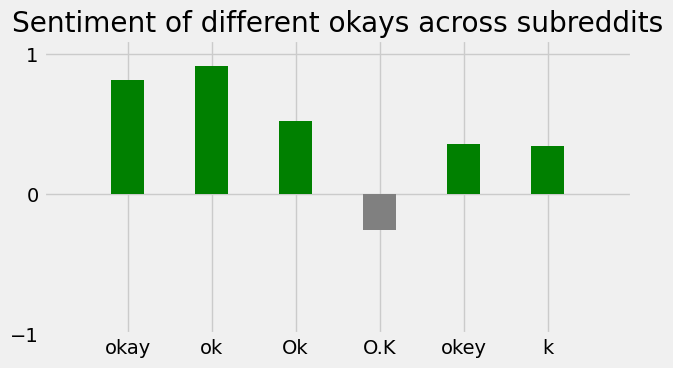

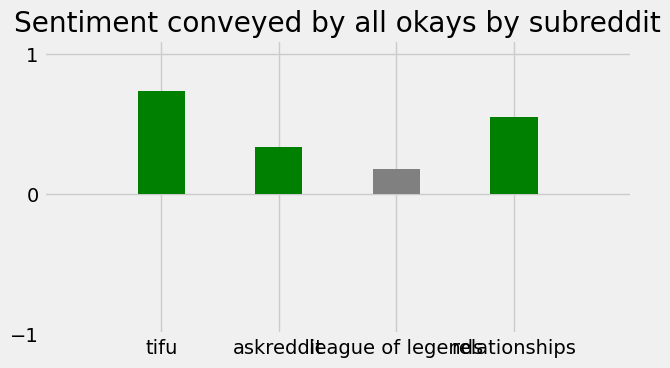

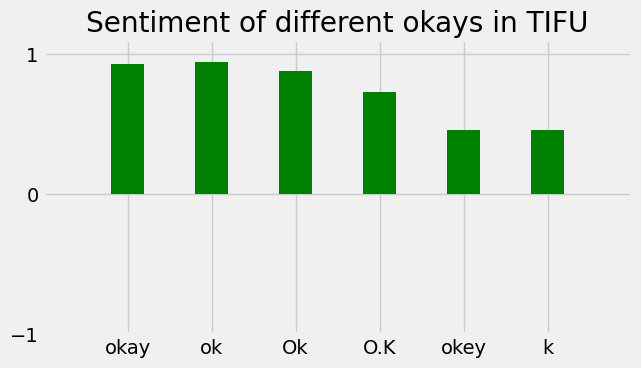

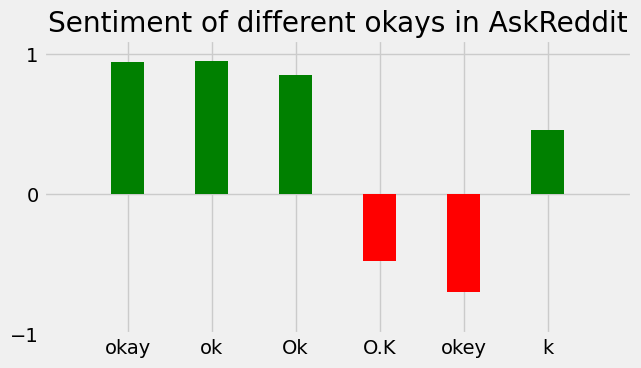

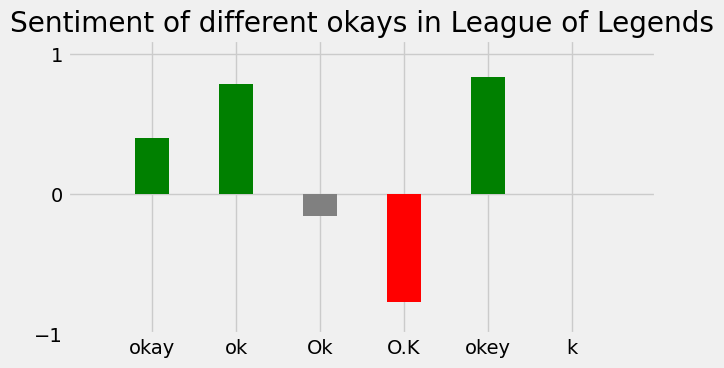

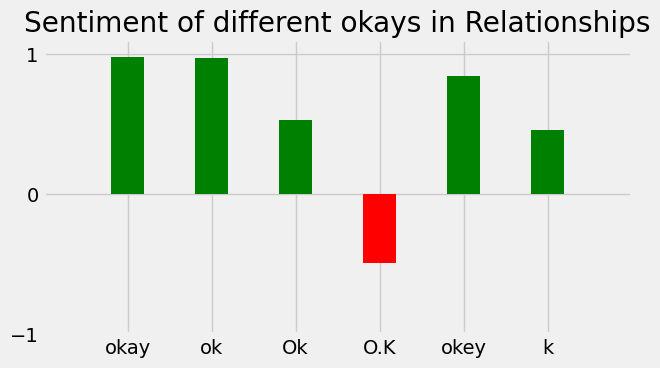

In [ ]:
def plot_sentiment(result, title):
  plt.style.use('_mpl-gallery') #fivethirtyeight

  # make data
  x = list(result.keys())
  y = list(result.values())

  # plot
  fig, ax = plt.subplots(figsize=(6, 3))

  # boundary for pos, neg, neu
  colors = []
  for i in y:
    if (i < -0.3):
      colors.append('red')
    elif (i > 0.3):
      colors.append('green')
    else:
      colors.append('grey')

  ax.bar(x, y, color=colors, width=0.4)
  ax.set(xlim=(-1, len(x)), xticks=np.arange(-1, len(x)),
          ylim=(-1, 1.1), yticks=np.arange(-1, 1.1))

  plt.title(title)
  plt.show()

plot_sentiment(result, "Sentiment of different okays across subreddits")
plot_sentiment({"tifu": sub_ok_sent(sent_tifu), "askreddit": sub_ok_sent(sent_askreddit), "league of legends": sub_ok_sent(sent_league), "relationships": sub_ok_sent(sent_relation)}, "Sentiment conveyed by all okays by subreddit")
plot_sentiment(sent_tifu, "Sentiment of different okays in TIFU")
plot_sentiment(sent_askreddit, "Sentiment of different okays in AskReddit")
plot_sentiment(sent_league, "Sentiment of different okays in League of Legends")
plot_sentiment(sent_relation, "Sentiment of different okays in Relationships")

# Similarity of different version of OK within subreddits

In [ ]:
# All possible pairs in List using combinations()
two_pair_ok = list(combinations(ok_list, 2))

#calculate (cosine) similarity between each 2 okays in each subreddit
for i in two_pair_ok:
  print("tifu: ", i[0], "-", i[1], ":", tifu_model.wv.similarity(i[0], i[1]))
  print("askreddit: ", i[0], "-", i[1], ":", askreddit_model.wv.similarity(i[0], i[1]))
  print("league of legends: ", i[0], "-", i[1], ":", league_model.wv.similarity(i[0], i[1]))
  print("relationships: ", i[0], "-", i[1], ":", relation_model.wv.similarity(i[0], i[1]))
  print("--------------------")

tifu:  okay - ok : 0.9644312
askreddit:  okay - ok : 0.9633913
league of legends:  okay - ok : 0.91181624
relationships:  okay - ok : 0.9602788
--------------------
tifu:  okay - Ok : 0.69454354
askreddit:  okay - Ok : 0.67521095
league of legends:  okay - Ok : 0.70300794
relationships:  okay - Ok : 0.5782855
--------------------
tifu:  okay - O.K : 0.6767231
askreddit:  okay - O.K : 0.7034212
league of legends:  okay - O.K : 0.5268352
relationships:  okay - O.K : 0.39459196
--------------------
tifu:  okay - okey : 0.5048425
askreddit:  okay - okey : 0.5634608
league of legends:  okay - okey : 0.6802433
relationships:  okay - okey : 0.6606879
--------------------
tifu:  okay - k : 0.3785937
askreddit:  okay - k : 0.44292423
league of legends:  okay - k : 0.42028376
relationships:  okay - k : 0.3992195
--------------------
tifu:  ok - Ok : 0.65990025
askreddit:  ok - Ok : 0.654334
league of legends:  ok - Ok : 0.61149603
relationships:  ok - Ok : 0.5361783
--------------------
tifu:  o

Plotting the similarity

https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

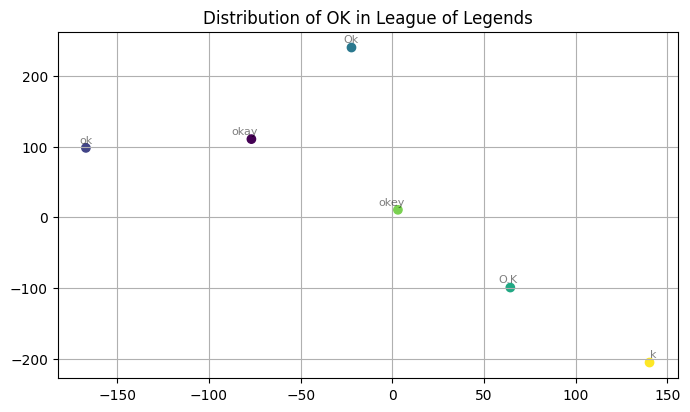

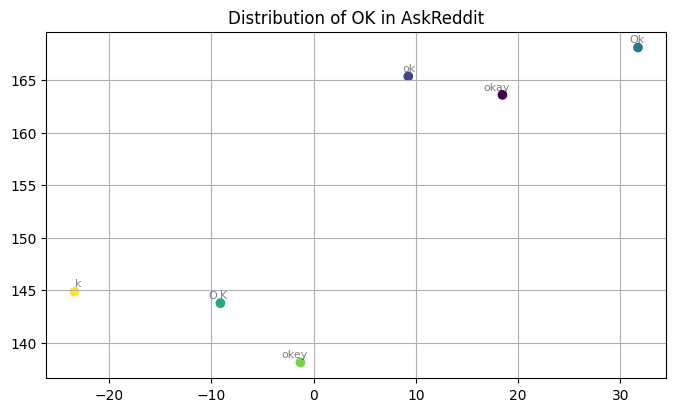

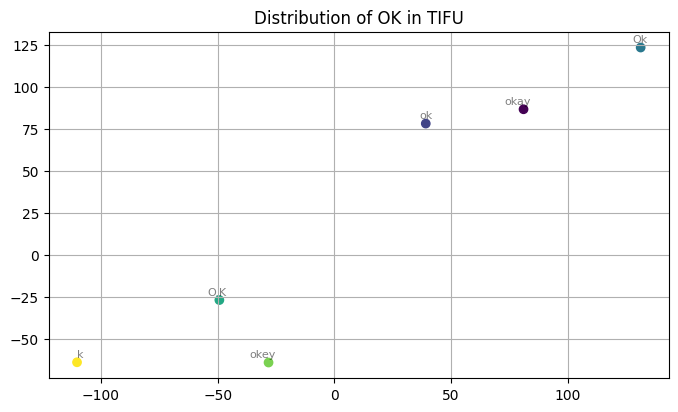

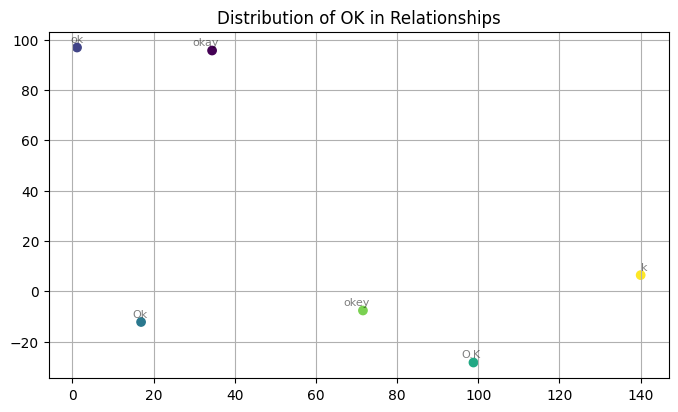

In [ ]:
def tsne_plot_2d(labels, model, title, filename=None):
    #one color for each word to plot
    colors = [cm.viridis(np.linspace(0, 1, len(labels)))]
    # get embeddings for each word and make array
    embeddings_ok = [model.wv[word] for word in labels]
    ok_vectors = np.array(embeddings_ok)

    # initiate "t-distributed Stochastic Neighbor Embedding" model
    # perplexity at 2 for visualisation
    # reduces the dimensionality of the word embeddings to 2D
    tsne_ok_2d = TSNE(perplexity=2, init='pca')
    embeddings_ok_2d = tsne_ok_2d.fit_transform(ok_vectors)
    # set figure size
    plt.figure(figsize=(8, 4.5))

    # plot the reduced embeddings
    x = embeddings_ok_2d[:, 0]
    y = embeddings_ok_2d[:, 1]
    for label, embedding, colors in zip(labels, embeddings_ok, colors): #
        plt.scatter(x, y, alpha=1, color=colors, label=label) #
        for i, word in enumerate(ok_list):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.title(title)
    plt.grid(True)

    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')

    plt.show()

tsne_plot_2d(ok_list, league_model, "Distribution of OK in League of Legends") #, "ok_lol.png"
tsne_plot_2d(ok_list, askreddit_model, "Distribution of OK in AskReddit") #, "ok_askred.png"
tsne_plot_2d(ok_list, tifu_model, "Distribution of OK in TIFU") #, "ok_tifu.png"
tsne_plot_2d(ok_list, relation_model,  "Distribution of OK in Relationships") #, "ok_relations.png"